# Post-synaptic response of a single synapse  in an active e-model

Adapted from https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-04.ipynb

Modified by  Darshan Mandge and Ilkan Kiliç, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

## Summary
In this notebook, you will be able to add a synapse on the soma of an e-model using LFPy. This notebook shows the users how they can use different synapses with the OBP e-models.

If you want to use a custom synapse, copy the mod file in the mechanisms directory and update the `syntype` in the below code with the POINT_PROCESS name of your synapse mod file.

## Get the data
We can get the data using the entitysdk package. It has a function dedicated to download a SimulatableNeuron (also called MEModel). It will download a hoc file, a morphology and mechanisms (ion channel models).

To download the files, execute the following cell, and click on the link to set up authentication with the platform. If the code does not work, you might have to update the memodel_id, since it can change after a new deployment of the database.

In [1]:
from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel


memodel_id = "59e584ec-5ab0-4e2c-a0c1-dab57a5e18b3"

token = get_token(environment="staging", auth_mode="daf")
client = Client(environment="staging", token_manager=token)

memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=memodel_id,
)
downloaded_memodel = download_memodel(
    client, memodel=memodel
)

Please open url in a different tab:  https://staging.openbraininstitute.org/auth/realms/SBO/device?user_code=RODW-HQPU


The local path to the output files can be fetched with the following cell. We can get the local hoc file path, the local morphology path, and the local mechanisms (i.e. the ion channel moddels) directory path.

In [2]:
hoc_file = downloaded_memodel.hoc_path
morph_file = downloaded_memodel.morphology_path
mechanisms_folder = downloaded_memodel.mechanisms_dir

Next you will have to compile the mechanisms.

In [4]:
!nrnivmodl {mechanisms_folder}

# Alternatively 
# import os
# os.system(f"{venv_path}/bin/nrnivmodl {mechanisms_folder}")

/Users/aurelien/venvs/venv-py312/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/aurelien/repos/obi_platform_analysis_notebooks/Cellular/emodels/lfpy_simulations/active_emodel_synapses
Mod files: "mechanisms/mechanisms/CaDynamics_DC0.mod" "mechanisms/mechanisms/Ca_HVA2.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/NaTg.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import LFPy

--No graphics will be displayed.


Then, create the cell object using the `LFPy.Cell` 
class, specifying the morphology file.
The passive mechanisms
are not switched on by default.

In [6]:
# cell = LFPy.Cell(morphology=f'{emodel_path}/C060114A5.asc', 
#                  custom_code=[f'{emodel_path}/model.hoc'],
#                  passive=False)

cell = LFPy.TemplateCell(morphology  = str(morph_file),
                templatefile = str(hoc_file),
                templatename = 'cADpyr_bin_4',                          # name of the template within templatefile. See the line starting with "begintemplate"
                templateargs = [0, str(morph_file.parent), str(morph_file.name)],
                #  custom_code=['cadpyr/model.hoc'],
                passive      = False,
                nsegs_method = None,
                dt = 2**-6,
                tstart = -159,
                tstop = 100,
                v_init = -60,
                celsius= 34,
                pt3d = True,
               )


Then, align apical dendrite with z-axis. The x and y axes were found by trial and error to achieve better visualisation:

In [7]:
# cell.set_rotation(x=4.98919, y=-4.33261, z=0.)
# cell.set_rotation(x=4.0, y=-4.0, z=0.0)
cell.set_rotation(x=4.98919, y=9.3, z=0)

One can now use `LFPy.Synapse` class to insert a single 
synapse onto the soma compartment, and set the spike time(s) using `LFPy.Synapse.set_spike_times()` method:

In [8]:
synapse = LFPy.Synapse(cell, 
                       idx=cell.get_idx("soma[0]"),
                       syntype='Exp2Syn', 
                       weight=0.0075, 
                       e=0, 
                       tau1=0.5,
                       tau2=2,
                       record_current=True)
synapse.set_spike_times(np.array([20., 40]))

We now have what we need in order to calculate the postsynaptic response,
using a built in method `LFPy.Cell.simulate()` to run the simulation.

In [9]:
cell.simulate()

Then 
plot the model geometry, synaptic current and somatic potential:

(-500.0, 500.0, -550.0, 750.0)

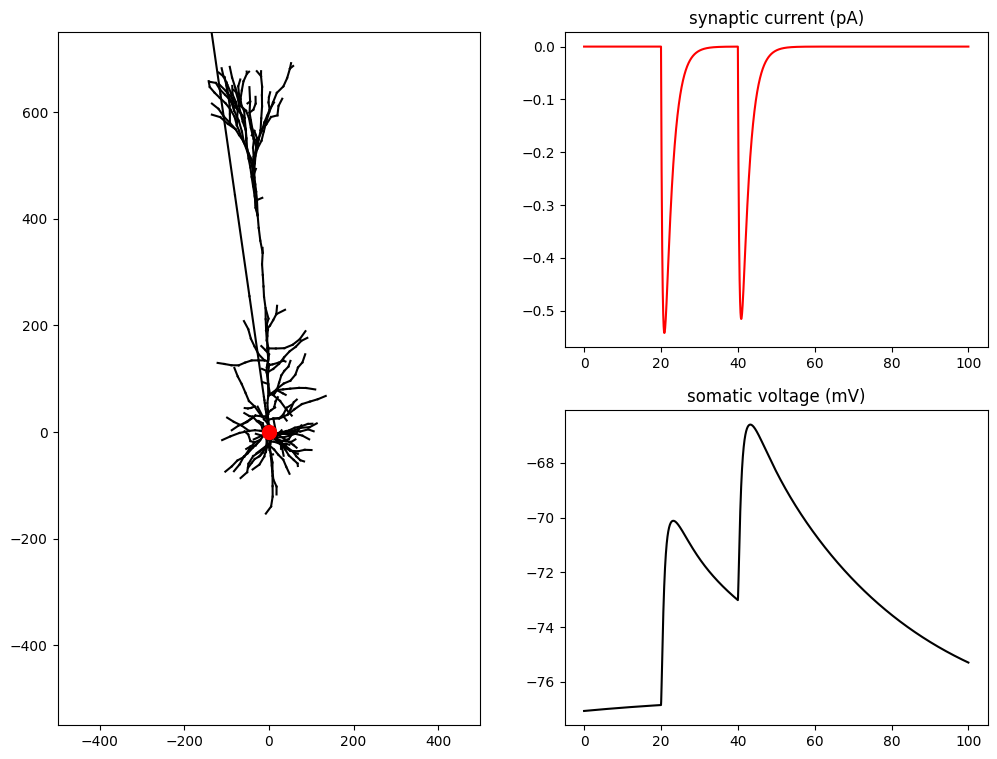

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(222)
plt.plot(cell.tvec, synapse.i, 'r')
plt.title('synaptic current (pA)')
plt.subplot(224)
plt.plot(cell.tvec, cell.somav, 'k')
plt.title('somatic voltage (mV)')
plt.subplot(121)
plt.plot(cell.x.T, cell.z.T, 'k')
plt.plot(synapse.x, synapse.z,
         color='r', marker='o', markersize=10)
plt.axis([-500, 500, -550, 750])

# savefig('LFPy-example-01.pdf', dpi=200)